# Learning to Control an Unknown Dynamical System

For this example we demonstrate learning a model-based control policy for an unknown dynamical system.

**Offline off-policy control learning scenario.**

In a typical real world control setting, due to cost and operational concerns, there is not an opportunity to directly interact with the system to learn a controller. The presented scenario has three stages:

+ Stage 1: the system is perturbed for some amount of time to collect measurements representative of the system state space. 
+ Stage 2: Learn a black-box [neural ordinary differential equation (NODE)](https://arxiv.org/abs/1806.07366) approximation of an unknown dynamical system given the time series data of system rollouts. 
+ Stage 3: Learn neural control policy by differentiating closed-loop dynamical system (neural policy + NODE) using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981). 

In the following cells we walk through the three stage process of generating data, system identification, and control policy learning using neuromancer. 

# NeuroMANCER and Dependencies

## Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

# Stage 1: data generation

## Instantiate a system emulator from neuromancer.psl

In [21]:
from neuromancer.psl.nonautonomous import Actuator
from neuromancer.dataset import DictDataset
# instantiate simulator model to be controlled - this mode represent an emulator of a controlled system
sys = Actuator()

## Generate datasets representative of system behavior

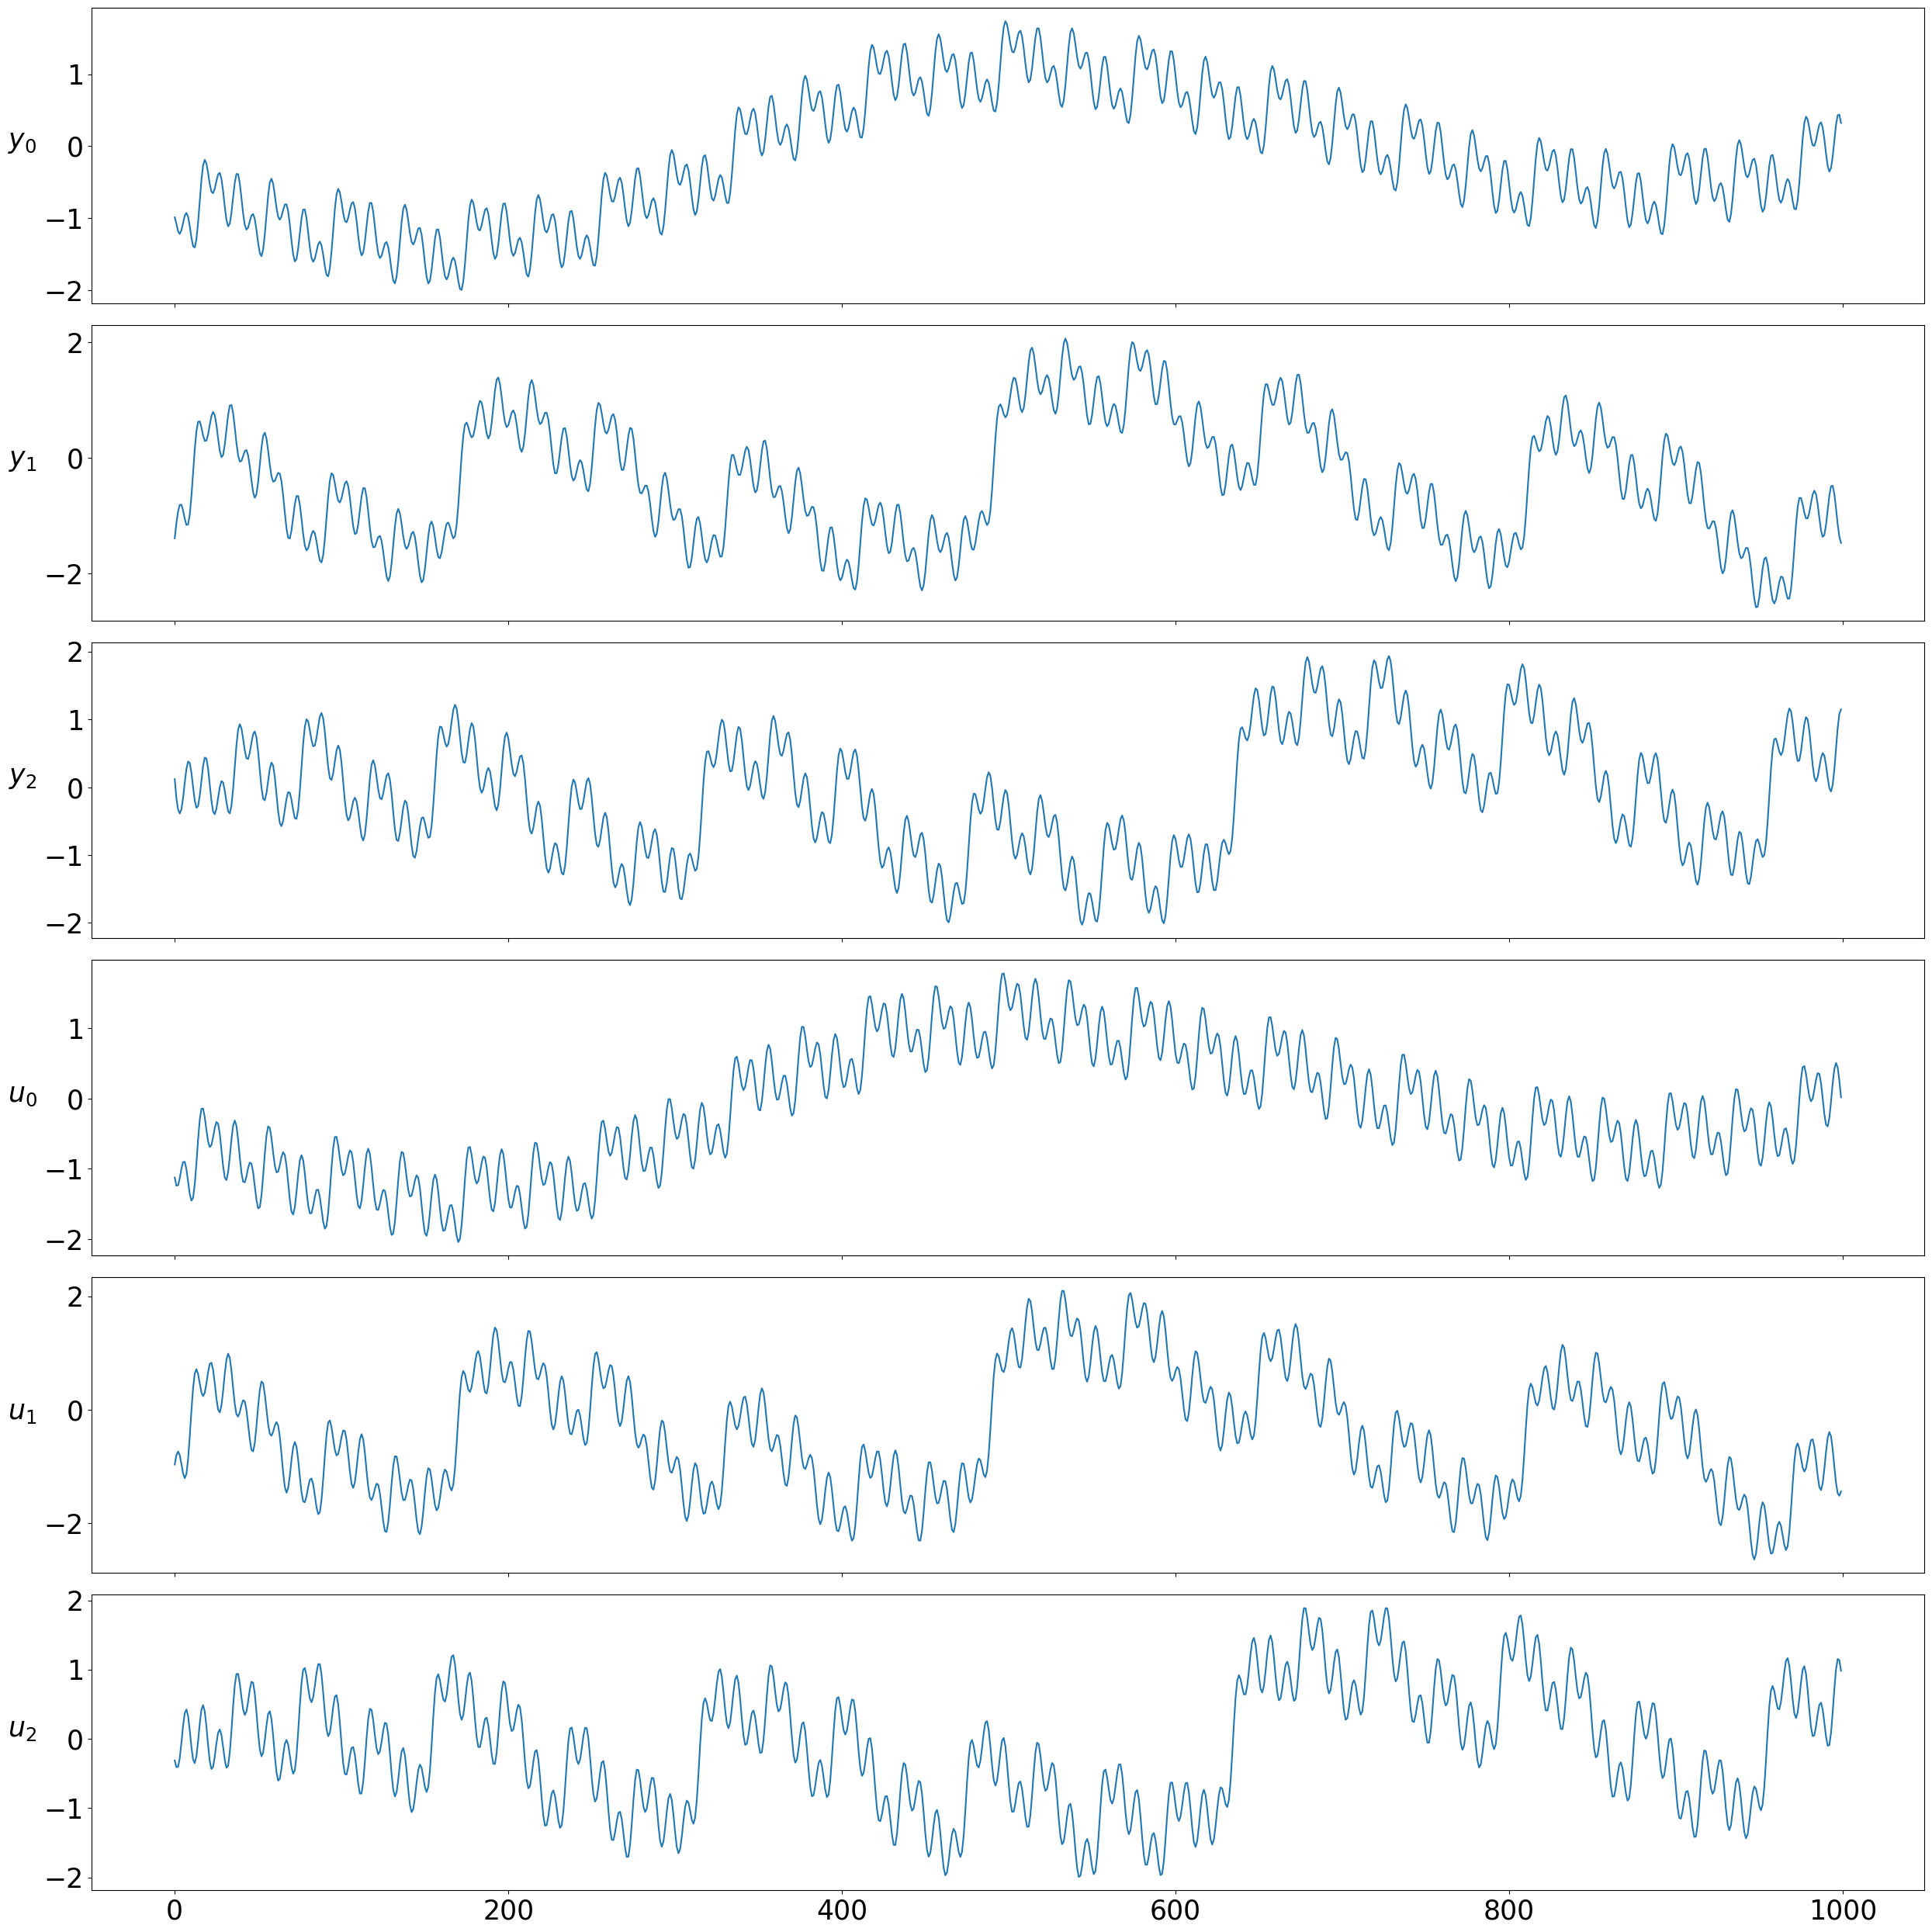

In [23]:
# obtain time series of the system to be controlled
train_data, dev_data, test_data = [sys.simulate(nsim=1000) for i in range(3)]

# normalize the dataset
train_data, dev_data, test_data = [sys.normalize(d) for d in [train_data, dev_data, test_data]]
# show the training data
sys.show(train_data)

In [24]:
# Set up the data to be in samples of 10 contiguous time steps 
# (100 samples with 10 time steps each last dim is dimension of the measured variable)
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(100, 10, 3)
    d['U'] = d['U'].reshape(100, 10, 3)
    d['Y'] = d['Y'].reshape(100, 10, 3)
    d['xn'] = d['X'][:, 0:1, :] # Add an initial condition to start the system loop
    d['Time'] = d['Time'].reshape(100, -1)
    
# create dataloaders
from torch.utils.data import DataLoader
train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) 
                            for d in [train_dataset, dev_dataset]]

# Stage 2: System Identification using Neural Ordinary Differential Equations

## Define a black-box NODE model 

In [22]:
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dynamics import integrators
import torch

# define neural ODE (NODE)
dx = blocks.MLP(sys.nx + sys.nu, sys.nx, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU,
              hsizes=[20 for h in range(3)])
interp_u = lambda tq, t, u: u
# we use ODE integrators to discretize continuous-time NODE model
integrator = integrators.Euler(dx, h=torch.tensor(0.1), interp_u=interp_u)
system_node = Node(integrator, ['xn', 'U'], ['xn'])
model = System([system_node])
# model.show()

## Define the NODE system identification optimization problem

In [25]:
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss

# Nstep rollout predictions from the model
xpred = variable('xn')[:, :-1, :]
# Ground truth data
xtrue = variable('X')
# define system identification loss function
loss = (xpred == xtrue) ^ 2
loss.update_name('loss')

# construct differentiable optimization problem in Neuromancer
obj = PenaltyLoss([loss], [])
problem = Problem([model], obj)

## Solve the NODE system identification problem

In [26]:
from neuromancer.trainer import Trainer
import torch.optim as optim

opt = optim.Adam(model.parameters(), 0.001)
trainer = Trainer(problem, train_loader, dev_loader, dev_loader, 
                  optimizer=opt,
                  epochs=1000,
                  patience=300,
                  train_metric='train_loss',
                  eval_metric='dev_loss')
best_model = trainer.train()

epoch: 0  train_loss: 0.21147073805332184
epoch: 1  train_loss: 0.20968355238437653
epoch: 2  train_loss: 0.20796750485897064
epoch: 3  train_loss: 0.2063206136226654
epoch: 4  train_loss: 0.20474059879779816
epoch: 5  train_loss: 0.20322494208812714
epoch: 6  train_loss: 0.20177052915096283
epoch: 7  train_loss: 0.2003740668296814
epoch: 8  train_loss: 0.19903235137462616
epoch: 9  train_loss: 0.19774232804775238
epoch: 10  train_loss: 0.19650118052959442
epoch: 11  train_loss: 0.19530603289604187
epoch: 12  train_loss: 0.1941540390253067
epoch: 13  train_loss: 0.19304244220256805
epoch: 14  train_loss: 0.19196847081184387
epoch: 15  train_loss: 0.1909293830394745
epoch: 16  train_loss: 0.1899224817752838
epoch: 17  train_loss: 0.1889452338218689
epoch: 18  train_loss: 0.18799513578414917
epoch: 19  train_loss: 0.1870698183774948
epoch: 20  train_loss: 0.18616704642772675
epoch: 21  train_loss: 0.1852845847606659
epoch: 22  train_loss: 0.18442033231258392
epoch: 23  train_loss: 0.1835

epoch: 194  train_loss: 0.010663248598575592
epoch: 195  train_loss: 0.010481997393071651
epoch: 196  train_loss: 0.010302114300429821
epoch: 197  train_loss: 0.01012359093874693
epoch: 198  train_loss: 0.009946420788764954
epoch: 199  train_loss: 0.009770614095032215
epoch: 200  train_loss: 0.009596183896064758
epoch: 201  train_loss: 0.009423157200217247
epoch: 202  train_loss: 0.009251557290554047
epoch: 203  train_loss: 0.009081426076591015
epoch: 204  train_loss: 0.008912798017263412
epoch: 205  train_loss: 0.008745715953409672
epoch: 206  train_loss: 0.008580220863223076
epoch: 207  train_loss: 0.008416363038122654
epoch: 208  train_loss: 0.008254189975559711
epoch: 209  train_loss: 0.008093747310340405
epoch: 210  train_loss: 0.007935084402561188
epoch: 211  train_loss: 0.00777825154364109
epoch: 212  train_loss: 0.007623294834047556
epoch: 213  train_loss: 0.007470257580280304
epoch: 214  train_loss: 0.007319187745451927
epoch: 215  train_loss: 0.007170127239078283
epoch: 216  

epoch: 377  train_loss: 0.0005442682304419577
epoch: 378  train_loss: 0.000540044333320111
epoch: 379  train_loss: 0.0005358900525607169
epoch: 380  train_loss: 0.0005318037583492696
epoch: 381  train_loss: 0.0005277841119095683
epoch: 382  train_loss: 0.0005238296580500901
epoch: 383  train_loss: 0.0005199392326176167
epoch: 384  train_loss: 0.0005161110311746597
epoch: 385  train_loss: 0.0005123441806063056
epoch: 386  train_loss: 0.0005086372839286923
epoch: 387  train_loss: 0.0005049888859502971
epoch: 388  train_loss: 0.0005013981135562062
epoch: 389  train_loss: 0.0004978632787242532
epoch: 390  train_loss: 0.0004943837993778288
epoch: 391  train_loss: 0.0004909579874947667
epoch: 392  train_loss: 0.00048758514458313584
epoch: 393  train_loss: 0.00048426410648971796
epoch: 394  train_loss: 0.0004809937090612948
epoch: 395  train_loss: 0.00047777302097529173
epoch: 396  train_loss: 0.0004746011400129646
epoch: 397  train_loss: 0.00047147684381343424
epoch: 398  train_loss: 0.00046

epoch: 558  train_loss: 0.0002534961386118084
epoch: 559  train_loss: 0.00025292130885645747
epoch: 560  train_loss: 0.00025235052453354
epoch: 561  train_loss: 0.0002517835237085819
epoch: 562  train_loss: 0.00025122053921222687
epoch: 563  train_loss: 0.00025066130911000073
epoch: 564  train_loss: 0.00025010594981722534
epoch: 565  train_loss: 0.00024955422850325704
epoch: 566  train_loss: 0.0002490062324795872
epoch: 567  train_loss: 0.0002484619617462158
epoch: 568  train_loss: 0.0002479212707839906
epoch: 569  train_loss: 0.0002473842178005725
epoch: 570  train_loss: 0.00024685056996531785
epoch: 571  train_loss: 0.00024632056010887027
epoch: 572  train_loss: 0.00024579395540058613
epoch: 573  train_loss: 0.00024527066852897406
epoch: 574  train_loss: 0.00024475090322084725
epoch: 575  train_loss: 0.0002442345139570534
epoch: 576  train_loss: 0.00024372132611460984
epoch: 577  train_loss: 0.00024321141245309263
epoch: 578  train_loss: 0.00024270484573207796
epoch: 579  train_loss:

epoch: 744  train_loss: 0.00018578628078103065
epoch: 745  train_loss: 0.0001855417067417875
epoch: 746  train_loss: 0.0001852978894021362
epoch: 747  train_loss: 0.00018505481421016157
epoch: 748  train_loss: 0.00018481236475054175
epoch: 749  train_loss: 0.00018457065743859857
epoch: 750  train_loss: 0.00018432957585901022
epoch: 751  train_loss: 0.00018408922187518328
epoch: 752  train_loss: 0.00018384953727945685
epoch: 753  train_loss: 0.00018361049296800047
epoch: 754  train_loss: 0.0001833721762523055
epoch: 755  train_loss: 0.00018313451437279582
epoch: 756  train_loss: 0.0001828975073294714
epoch: 757  train_loss: 0.0001826612133299932
epoch: 758  train_loss: 0.0001824254431994632
epoch: 759  train_loss: 0.00018219047342427075
epoch: 760  train_loss: 0.00018195602751802653
epoch: 761  train_loss: 0.0001817222364479676
epoch: 762  train_loss: 0.00018148912931792438
epoch: 763  train_loss: 0.00018125661881640553
epoch: 764  train_loss: 0.00018102479225490242
epoch: 765  train_lo

epoch: 928  train_loss: 0.00014930045290384442
epoch: 929  train_loss: 0.00014913626364432275
epoch: 930  train_loss: 0.00014897224900778383
epoch: 931  train_loss: 0.00014880849630571902
epoch: 932  train_loss: 0.00014864507829770446
epoch: 933  train_loss: 0.00014848190767224878
epoch: 934  train_loss: 0.00014831899898126721
epoch: 935  train_loss: 0.00014815643953625113
epoch: 936  train_loss: 0.00014799402561038733
epoch: 937  train_loss: 0.00014783188817091286
epoch: 938  train_loss: 0.00014767002721782774
epoch: 939  train_loss: 0.0001475085155107081
epoch: 940  train_loss: 0.00014734720753040165
epoch: 941  train_loss: 0.0001471861032769084
epoch: 942  train_loss: 0.0001470253337174654
epoch: 943  train_loss: 0.00014686482609249651
epoch: 944  train_loss: 0.00014670455129817128
epoch: 945  train_loss: 0.00014654452388640493
epoch: 946  train_loss: 0.00014638477296102792
epoch: 947  train_loss: 0.00014622525486629456
epoch: 948  train_loss: 0.00014606601325795054
epoch: 949  trai

## Evaluate the learned NODE system model on 1000 time step rollout

{'Y': (1000, 3), 'X': (1000, 3), 'U': (1000, 3), 'Time': (1000,)}


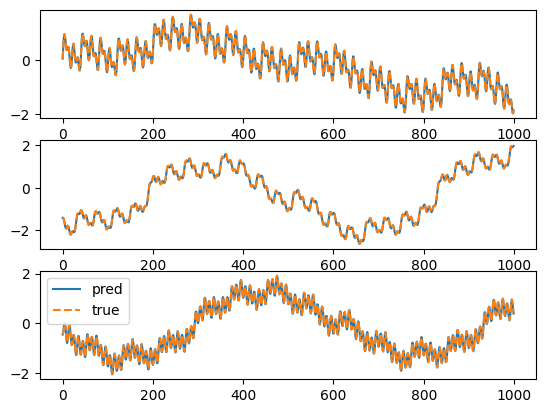

In [27]:
import torch
test_data = sys.normalize(sys.simulate(nsim=1000))
print({k: v.shape for k, v in test_data.items()})

test_data['X'] = test_data['X'].reshape(1, *test_data['X'].shape)
test_data['U'] = test_data['U'].reshape(1, *test_data['U'].shape)
test_data['xn'] = test_data['X'][:, 0:1, :]
test_data = {k: torch.tensor(v, dtype=torch.float32) for k, v in test_data.items()}
test_output = model(test_data)

import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_output['xn'][0, :-1, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['X'][0, :, v].detach().numpy(), '--', label='true')
plt.legend()

# Stage 3: Learning control policy using Differentiable Predictive Control 

**Differentiable Predictive Control method**:  
The [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981) is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In DPC, we construct a differentiable closed-loop system composed of neural control policy and system dynamics model that is to be optimized using parametric control objectives as intrinsic reward signals evaluated over a sampled distribution of the problem parameters.

<img src="./figs/DPC_simple_method.png" width="600">  

## Create a closed loop system using the NODE model and a neural control policy


In [28]:
nx, nu = sys.nx, sys.nu

# define neural control policy class
class Policy(torch.nn.Module):

    def __init__(self, insize, outsize):
        super().__init__()
        self.net = blocks.MLP(insize, outsize, bias=True, hsizes=[20, 20, 20])

    def forward(self, x, R):
        features = torch.cat([x, R], dim=-1)
        return self.net(features)

insize = 2*nx
policy = Policy(insize, nu)
# symbolic representation of a control policy mapping measured states and predicted reference trajectories onto control actions
policy_node = Node(policy, ['xn', 'R'], ['U'], name='policy')
cl_system = System([policy_node, system_node], name='cl_system')
# cl_system.show()

## Sample dataset of control parameters 

For this simple Actuator system the same dataset can be used for learning a control policy as we used to learn the system model. Here we wish to optimize  controlling the system to some reference trajectory R.

In [29]:
train_dataset = DictDataset({'R': train_data['X'], 'X': train_data['X'], 'xn': train_data['xn']}, name='train')
dev_dataset = DictDataset({'R': dev_data['X'], 'X': train_data['X'], 'xn': dev_data['xn']}, name='dev')
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) 
                            for d in [train_dataset, dev_dataset]]

## Define objectives and of the optimal control problem

In [30]:
tru = variable('xn')[:, 1:, :]  # system states
ref = variable('R')             # reference 
u = variable('U')               # control action
# reference tracking objective
loss = (ref == tru) ^ 2
loss.update_name('loss')

# differentiable optimal control problem
obj = PenaltyLoss([loss], [])
problem = Problem([cl_system], obj)

## Optimize the control policy

In [31]:
opt = optim.Adam(policy.parameters(), 0.01)
logout = ['loss']
trainer = Trainer(problem, train_loader, dev_loader, dev_loader,
                  optimizer=opt,
                  epochs=1000,
                  patience=1000,
                  train_metric='train_loss',
                  eval_metric='dev_loss')

best_model = trainer.train()
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 0.7101645469665527
epoch: 1  train_loss: 0.5665475726127625
epoch: 2  train_loss: 0.41896072030067444
epoch: 3  train_loss: 0.28537970781326294
epoch: 4  train_loss: 0.2526082694530487
epoch: 5  train_loss: 0.21122859418392181
epoch: 6  train_loss: 0.17227685451507568
epoch: 7  train_loss: 0.11596889048814774
epoch: 8  train_loss: 0.07415852695703506
epoch: 9  train_loss: 0.05963251739740372
epoch: 10  train_loss: 0.056046925485134125
epoch: 11  train_loss: 0.052582111209630966
epoch: 12  train_loss: 0.05401360243558884
epoch: 13  train_loss: 0.056082505732774734
epoch: 14  train_loss: 0.04928772151470184
epoch: 15  train_loss: 0.04027070477604866
epoch: 16  train_loss: 0.03391006588935852
epoch: 17  train_loss: 0.02779843471944332
epoch: 18  train_loss: 0.021014563739299774
epoch: 19  train_loss: 0.01580735296010971
epoch: 20  train_loss: 0.01405746303498745
epoch: 21  train_loss: 0.015299073420464993
epoch: 22  train_loss: 0.017474545165896416
epoch: 23  train_l

epoch: 181  train_loss: 0.00020139805565122515
epoch: 182  train_loss: 0.00020009245781693608
epoch: 183  train_loss: 0.00019880157196894288
epoch: 184  train_loss: 0.00019752504886128008
epoch: 185  train_loss: 0.00019626309222076088
epoch: 186  train_loss: 0.00019501498900353909
epoch: 187  train_loss: 0.00019378052093088627
epoch: 188  train_loss: 0.0001925600372487679
epoch: 189  train_loss: 0.00019135299953632057
epoch: 190  train_loss: 0.0001901595387607813
epoch: 191  train_loss: 0.00018897942209150642
epoch: 192  train_loss: 0.00018781260587275028
epoch: 193  train_loss: 0.00018665917741600424
epoch: 194  train_loss: 0.00018551880202721804
epoch: 195  train_loss: 0.00018439136329106987
epoch: 196  train_loss: 0.000183276497409679
epoch: 197  train_loss: 0.00018217446631751955
epoch: 198  train_loss: 0.0001810849498724565
epoch: 199  train_loss: 0.00018000788986682892
epoch: 200  train_loss: 0.00017894315533339977
epoch: 201  train_loss: 0.0001778907171683386
epoch: 202  train_l

epoch: 363  train_loss: 0.0001046924662659876
epoch: 364  train_loss: 0.00010456518066348508
epoch: 365  train_loss: 0.00010443979408591986
epoch: 366  train_loss: 0.00010431614646222442
epoch: 367  train_loss: 0.00010419420141261071
epoch: 368  train_loss: 0.0001040740025928244
epoch: 369  train_loss: 0.00010395557910669595
epoch: 370  train_loss: 0.00010383877815911546
epoch: 371  train_loss: 0.00010372367250965908
epoch: 372  train_loss: 0.00010361013846704736
epoch: 373  train_loss: 0.00010349832155043259
epoch: 374  train_loss: 0.00010338806168874726
epoch: 375  train_loss: 0.00010327937343390658
epoch: 376  train_loss: 0.00010317220585420728
epoch: 377  train_loss: 0.00010306662443326786
epoch: 378  train_loss: 0.00010296252730768174
epoch: 379  train_loss: 0.00010285991447744891
epoch: 380  train_loss: 0.00010275887325406075
epoch: 381  train_loss: 0.00010265920718666166
epoch: 382  train_loss: 0.00010256085806759074
epoch: 383  train_loss: 0.0001024641387630254
epoch: 384  trai

epoch: 541  train_loss: 9.671793668530881e-05
epoch: 542  train_loss: 9.671018779044971e-05
epoch: 543  train_loss: 9.670249710325152e-05
epoch: 544  train_loss: 9.669493738329038e-05
epoch: 545  train_loss: 9.668757411418483e-05
epoch: 546  train_loss: 9.668023267295212e-05
epoch: 547  train_loss: 9.667308768257499e-05
epoch: 548  train_loss: 9.666605910751969e-05
epoch: 549  train_loss: 9.665918332757428e-05
epoch: 550  train_loss: 9.665230754762888e-05
epoch: 551  train_loss: 9.66456500464119e-05
epoch: 552  train_loss: 9.663912351243198e-05
epoch: 553  train_loss: 9.663259697845206e-05
epoch: 554  train_loss: 9.662630327511579e-05
epoch: 555  train_loss: 9.66201041592285e-05
epoch: 556  train_loss: 9.661392687121406e-05
epoch: 557  train_loss: 9.66078951023519e-05
epoch: 558  train_loss: 9.66019433690235e-05
epoch: 559  train_loss: 9.659615170676261e-05
epoch: 560  train_loss: 9.659046190790832e-05
epoch: 561  train_loss: 9.658481576479971e-05
epoch: 562  train_loss: 9.657929331297

epoch: 726  train_loss: 9.629146370571107e-05
epoch: 727  train_loss: 9.629120177123696e-05
epoch: 728  train_loss: 9.629094711272046e-05
epoch: 729  train_loss: 9.629064879845828e-05
epoch: 730  train_loss: 9.629043051972985e-05
epoch: 731  train_loss: 9.629018313717097e-05
epoch: 732  train_loss: 9.628992120269686e-05
epoch: 733  train_loss: 9.628977568354458e-05
epoch: 734  train_loss: 9.628954285290092e-05
epoch: 735  train_loss: 9.628929547034204e-05
epoch: 736  train_loss: 9.628912812331691e-05
epoch: 737  train_loss: 9.628888074075803e-05
epoch: 738  train_loss: 9.628872794564813e-05
epoch: 739  train_loss: 9.628846601117402e-05
epoch: 740  train_loss: 9.628824045648798e-05
epoch: 741  train_loss: 9.628807310946286e-05
epoch: 742  train_loss: 9.628790576243773e-05
epoch: 743  train_loss: 9.628772386349738e-05
epoch: 744  train_loss: 9.62875274126418e-05
epoch: 745  train_loss: 9.628736006561667e-05
epoch: 746  train_loss: 9.62871708907187e-05
epoch: 747  train_loss: 9.6287039923

epoch: 911  train_loss: 9.627895633457229e-05
epoch: 912  train_loss: 9.627895633457229e-05
epoch: 913  train_loss: 9.627895633457229e-05
epoch: 914  train_loss: 9.627894905861467e-05
epoch: 915  train_loss: 9.627894905861467e-05
epoch: 916  train_loss: 9.627894905861467e-05
epoch: 917  train_loss: 9.627888357499614e-05
epoch: 918  train_loss: 9.627889812691137e-05
epoch: 919  train_loss: 9.627889812691137e-05
epoch: 920  train_loss: 9.627889812691137e-05
epoch: 921  train_loss: 9.627892723074183e-05
epoch: 922  train_loss: 9.627890540286899e-05
epoch: 923  train_loss: 9.627888357499614e-05
epoch: 924  train_loss: 9.627890540286899e-05
epoch: 925  train_loss: 9.627890540286899e-05
epoch: 926  train_loss: 9.627885447116569e-05
epoch: 927  train_loss: 9.627888357499614e-05
epoch: 928  train_loss: 9.627886902308092e-05
epoch: 929  train_loss: 9.627885447116569e-05
epoch: 930  train_loss: 9.62789126788266e-05
epoch: 931  train_loss: 9.627892723074183e-05
epoch: 932  train_loss: 9.627887629

<All keys matched successfully>

## Evaluating the control policy on the true system

With the optional pytorch backend for the original ODE system we can now swap out our learned model to evaluate the learned control policy on the original system. 

In [32]:
sys.change_backend('torch')
# We will have to denormalize the policy actions according to the system stats
# Conversely we will have to normalize the system states according to the system stats to hand to the policy

def norm(x):
    return sys.normalize(x, key='X')

def denorm(u):
    return sys.denormalize(u, key='U')

normnode = Node(norm, ['xsys'], ['xn'], name='norm')
denormnode = Node(denorm, ['U'], ['u'], name='denorm')
sysnode = Node(sys, ['xsys', 'u'], ['xsys'], name='actuator')
test_system = System([normnode, policy_node, denormnode, sysnode])
# test_system.show()


## Evaluate on 1000 steps with a new reference trajectory distribution

{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1, 3]), 'Time': (1, 1000, 1)}
{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1001, 3]), 'Time': (1, 1000, 1), 'xn': torch.Size([1, 1000, 3]), 'U': torch.Size([1, 1000, 3]), 'u': torch.Size([1, 1000, 3])}


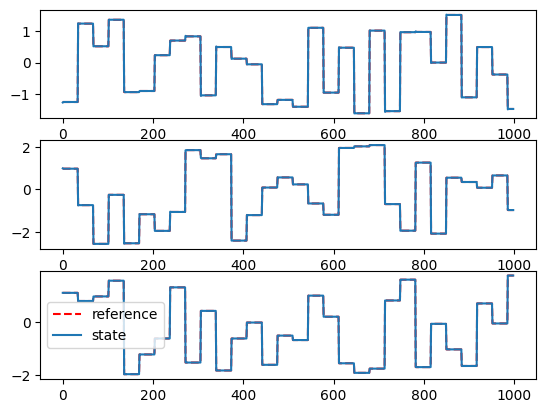

In [33]:
from neuromancer.psl.signals import sines, step, arma, spline
import numpy as np

# generate random sequence of step changes
references = step(nsim=1000, d=sys.nx, min=sys.stats['X']['min'], max=sys.stats['X']['max'])
test_data = {'R': torch.tensor(sys.normalize(references, key='X'), dtype=torch.float32).unsqueeze(0), 'xsys': sys.get_x0().reshape(1, 1, -1),
            'Time': (np.arange(1000)*sys.ts).reshape(1, 1000, 1)}
print({k: v.shape for k, v in test_data.items()})
test_system.nsteps=1000
with torch.no_grad():
    test_out = test_system(test_data)

print({k: v.shape for k, v in test_out.items()})
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_data['R'][0, :, v].detach().numpy(), 'r--', label='reference')
    ax[v].plot(test_out['xn'][0, 1:, v].detach().numpy(), label='state')
plt.legend()
plt.savefig('control.png')
